In [4]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


## 1. Gathering the table with Ronnie Dio's studio albums

In [106]:
bands = ['elf', 'rainbow', 'black_sabbath', 'dio']

rainbow_dio = ["Ritchie Blackmore's Rainbow", "Rising", "Rainbow Rising", "Long Live Rock'n'Roll"]
black_sabbath_dio = ["Heaven Hell", "Mob Rules", "Live Evil", "Dehumanizer"]
dio_live_dio = ["Intermission", "Strange Highways", "Inferno: Last In Live"]
ronnie_discography = []

for band in bands:
    lyrics_df = pd.read_csv('discography/' + band + '_discography_allthelyrics.csv', sep='\t', encoding='utf-8')
    lyrics_df['band'] = band
    if lyrics_df['band'].isin(['rainbow']).any():
        lyrics_df = lyrics_df[lyrics_df['album'].isin(rainbow_dio)]
    if lyrics_df['band'].isin(['black_sabbath']).any():
        lyrics_df = lyrics_df[lyrics_df['album'].isin(black_sabbath_dio)]
    if lyrics_df['band'].isin(['dio']).any():
        lyrics_df = lyrics_df[~lyrics_df['album'].isin(dio_live_dio)]
    ronnie_discography.append(lyrics_df)
    
ronnie_discography = pd.concat(ronnie_discography)
ronnie_discography


,song,link,album,lyrics,band
0,Ain't It All Amusing,https://www.allthelyrics.com/lyrics/elf/aint_i...,Carolina County Ball,"Baby if you flatter me, you might get somewher...",elf
1,Annie New Orleans,https://www.allthelyrics.com/lyrics/elf/annie_...,Carolina County Ball,Aggravatin' Annie you're getting on my fanny\n...,elf
2,Black Swampy Water,https://www.allthelyrics.com/lyrics/elf/black_...,Trying To Burn The Sun,Oh yeah\nUh back in the wood\nWhere it's good\...,elf
3,Blanche,https://www.allthelyrics.com/lyrics/elf/blanch...,Carolina County Ball,"Rainy days, rainy days\nToo many rainy days\nI...",elf
4,Carolina County Ball,https://www.allthelyrics.com/lyrics/elf/caroli...,Carolina County Ball,Well just imagine my surprise to be there\nIf ...,elf
...,...,...,...,...,...
101,Walk On Water,https://www.allthelyrics.com/lyrics/dio/walk_o...,Lock Up The Wolves,It's just a matter of time\nHe was the victim ...,dio
102,We Rock,https://www.allthelyrics.com/lyrics/dio/we_roc...,The Last In Line,He's just an ordinary man\nNever gonna live fo...,dio
103,When A Woman Cries,https://www.allthelyrics.com/lyrics/dio/when_a...,Dream Evil,You watch their faces\nYou'll see the traces\n...,dio
104,Why Are They Watching Me,https://www.allthelyrics.com/lyrics/dio/why_ar...,Lock Up The Wolves,Rain falls\nThunder cracks the air\nLightning ...,dio


In [59]:
# albums = ronnie_discography[['band','album','song']].groupby(['band','album'])['song'].count()
# albums

In [107]:
ronnie_discography[['band','album']].groupby(['band']).nunique()

,album
band,
black_sabbath,4
dio,10
elf,3
rainbow,3


In [125]:
# ronnie_discography[ronnie_discography['band'] == 'dio']['album'].drop_duplicates()

## 2. Setting lists for tf-idf

In [109]:
# limit = 50
limit = len(ronnie_discography)
key_list = list(ronnie_discography['song'])[:limit]
lyrics_list = list(ronnie_discography['lyrics'])[:limit]


In [110]:
bands_lyrics_dict = {}

for band in bands:
    bands_lyrics_dict[band] = list(ronnie_discography[ronnie_discography['band'] == band]['lyrics'])
    
bands_lyrics_dict

{'elf': ["Baby if you flatter me, you might get somewhere\nBut I ain't gonna flatter you 'coz I don't really care\nAin't it all, ain't it all amusing\nNow, now maybe if you get the sign, I might be a man\nBaby you forgot the time, I'll do the best I can\nAin't it all, ain't it all, ain't it all amusing\nWell, ain't it all, right, right, ain't it all amusing\nMake me laugh.....\nHey, Jack and Jill went up the hill\nTo fetch a pail of water\nJill fell down and broke her crown\nAnd that's the way it oughta.....\nWell, ain't it all now, all now, all, ain't it all amusing\nI say, ain't it all, right, ain't it all amusing\nOh, oh yeah\nOh, Baby if you flatter me, you might get somewhere\nBut I ain't gonna flatter you 'coz I don't really care\nAin't it all, ain't it all amusing\nHa-ha\nWell, ain't it all, right, right, ain't it all amusing\nAll amusing",
  "Aggravatin' Annie you're getting on my fanny\nAnd I just can't cope any more\nWhen it gets down to fundamentals\nYou're a bit confusing\n

## 3. Functions for tokenization

In [63]:
import nltk
from nltk.tokenize import word_tokenize

In [64]:
stopwords = nltk.corpus.stopwords.words('english')
# stopwords

In [65]:
# Stemming is just the process of breaking a word down into its root.
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [66]:
#

def tokenize_and_stem(text, stopwords=stopwords, lang="english"):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text, language=lang) for word in nltk.word_tokenize(sent, language=lang) if word.lower() not in stopwords]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text, stopwords, lang="english"):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text, language=lang) for word in nltk.word_tokenize(sent, language=lang) if word.lower() not in stopwords]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens



In [75]:
def totalvocab_creating(lyrics_list, stopwords, lang="english"):
    totalvocab_stemmed = []
    totalvocab_tokenized = []

    for i in lyrics_list:
        allwords_stemmed = tokenize_and_stem(i, stopwords, lang)
        totalvocab_stemmed.extend(allwords_stemmed)

        allwords_tokenized = tokenize_only(i, stopwords, lang)
        totalvocab_tokenized.extend(allwords_tokenized)

    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
#     print(vocab_frame.shape[0])

    return vocab_frame, totalvocab_tokenized, totalvocab_stemmed

In [74]:
# totalvocab_stemmed = []
# totalvocab_tokenized = []

# for i in lyrics_list:
#     allwords_stemmed = tokenize_and_stem(i, stopwords, "english")
#     totalvocab_stemmed.extend(allwords_stemmed)
    
#     allwords_tokenized = tokenize_only(i, stopwords, "english")
#     totalvocab_tokenized.extend(allwords_tokenized)
    
# vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
# print(vocab_frame.shape[0])

## 4. Tf-idf

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [121]:
# alternative way, with own list of stop words
# https://stackoverflow.com/questions/26826002/adding-words-to-stop-words-list-in-tfidfvectorizer-in-sklearn

tfidf_vectorizer = TfidfVectorizer(
    max_features=200, 
    max_df=0.7, 
    min_df=0.3, # 0.05
#     ngram_range=(1,1), 
    tokenizer=tokenize_and_stem, 
    stop_words=stopwords
)

tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics_list) # БЕРЕТСЯ ОРИГИНАЛЬНЫЙ ТЕКСТ, БЕЗ stemmed
# idf_values = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))
terms = tfidf_vectorizer.get_feature_names_out()

print(tfidf_matrix.shape)

(153, 20)


/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [84]:
def tfidf_params(tfidf_vectorizer, lyrics_list):
    tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics_list) # БЕРЕТСЯ ОРИГИНАЛЬНЫЙ ТЕКСТ, БЕЗ stemmed
#     idf_values = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))
    terms = tfidf_vectorizer.get_feature_names_out()

    return tfidf_matrix, terms

In [111]:
bands_tfidf_params_dict = {}

for band in bands:
    bands_tfidf_params_dict[band] = tfidf_params(tfidf_vectorizer, bands_lyrics_dict[band])
    
bands_tfidf_params_dict['elf'][0]

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<24x191 sparse matrix of type '<class 'numpy.float64'>'
	with 689 stored elements in Compressed Sparse Row format>

## 5. Top of Bag of Words

In [116]:
def top_of_words(tfidf_matrix, top_n=20):
    tfidf_array = tfidf_matrix.todense()
    tfidf_df = pd.DataFrame(tfidf_array)

    # flags of occurance 
    tfidf_flags_df = tfidf_df[list(tfidf_df)]
    for col in list(tfidf_df):
        tfidf_flags_df[col] = np.sign(tfidf_flags_df[col])

    # frequency of features
    feature_frequency = pd.DataFrame(np.sum(tfidf_flags_df)).rename(columns={0:'count'})

    # russian words of features
    terms_df = pd.DataFrame(terms).rename(columns={0:'token'})

    # Top-20 of most frequent tokens
    tfidf_feature_df = pd.concat([feature_frequency, terms_df], axis=1).sort_values(by='count', ascending=False)
    tfidf_feature_df.head(20)

    exceptions = ["n't", "'m", "yeah", "oh", "na", "ca"]

    return tfidf_feature_df[~tfidf_feature_df['token'].isin(exceptions)].head(top_n)


In [122]:
top_of_words(tfidf_matrix, 20)

,count,token
12,86.0,never
8,79.0,know
2,70.0,come
16,69.0,see
7,68.0,got
17,64.0,time
15,62.0,one
1,61.0,away
9,57.0,like
6,55.0,go


In [112]:
for band in bands:
    print(band)
    print(top_of_words(bands_tfidf_params_dict[band][0], 20))
    print()

elf
     count     token
178   13.0      turn
154   12.0  somebodi
50    12.0      fall
53    11.0      fire
65    11.0      gone
127   10.0     queen
84     9.0      know
41     9.0     dream
28     9.0      citi
22     9.0      call
56     9.0       fli
75     9.0       hey
135    8.0      road
105    8.0     might
76     8.0      hide
13     8.0     begin
14     8.0    behind
95     7.0      long
93     7.0      line
134    7.0     right

rainbow
     count     token
91    10.0     light
190    9.0      wish
114    8.0       new
67     8.0       got
180    8.0        us
111    8.0      name
37     8.0       day
141    7.0      sail
7      7.0     anoth
63     7.0        go
9      6.0      away
52     6.0      find
112    6.0      need
90     6.0      life
57     6.0      fool
64     6.0       gon
175    6.0  tomorrow
179    5.0      upon
184    5.0      want
94     5.0      live

black_sabbath
     count   token
98    16.0    lost
173   16.0   today
102   16.0    make
83    15.0    

## 6. ...

In [17]:
from scipy.cluster.vq import kmeans, vq

In [118]:
num_clusters = 3
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)

In [123]:
# terms = tfidf_vectorizer.get_feature_names_out()

for i in range(num_clusters):
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms[:10])

['time', "'m", 'oh', 'way', 'eye', 'see', 'get', 'never', 'got', 'come']
['come', 'one', 'feel', 'got', "n't", 'yeah', 'like', 'eye', 'get', 'night']
["n't", 'see', 'got', 'way', 'night', 'get', "'m", 'eye', 'never', 'look']


## 7. the elbow method

In [72]:
from scipy.cluster.vq import kmeans, vq

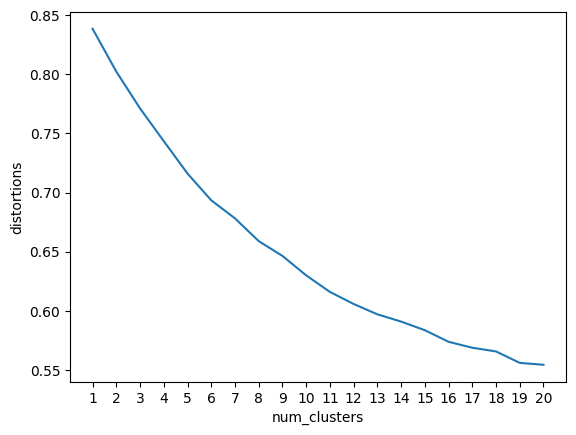

In [124]:
distortions = []
num_clusters_range = range(1, 21)

# Create a list of distortions from the kmeans method
for i in num_clusters_range:
    cluster_centers, distortion = kmeans(tfidf_matrix.todense(), i)
    distortions.append(distortion) 
    
# Create a DataFrame with two lists - number of clusters and distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters_range,
                           'distortions': distortions})
# Creat a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters_range)
plt.show()

# ======== DRAFTS: